# **Generating Fake Fruits using DCGAN**

## **Unzip Dataset**

In [6]:
from google.colab import files
uploaded = files.upload()

Saving fruit_dataset.zip to fruit_dataset.zip


In [7]:
import zipfile

zip_file_name = '/content/fruit_dataset.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content')

## **Importing Libraries**

In [8]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

## **Plot Images**

In [15]:
import os
import random
from PIL import Image

def load_random_images(base_path, num_images=5):
    classes = ['apple', 'banana', 'mango', 'orange']
    images = {}

    for fruit in classes:
        fruit_path = os.path.join(base_path, 'Train', fruit)
        all_images = os.listdir(fruit_path)
        selected_images = random.sample(all_images, num_images)
        images[fruit] = [os.path.join(fruit_path, img) for img in selected_images]

    return images

In [16]:
def plot_images(images):
    num_classes = len(images)
    num_images_per_class = len(images[next(iter(images))])

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 10))

    for i, (fruit, img_paths) in enumerate(images.items()):
        for j, img_path in enumerate(img_paths):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            # Set title for each image
            axes[i, j].set_title(fruit.capitalize(), fontsize=10, pad=5)

    plt.tight_layout()
    plt.show()

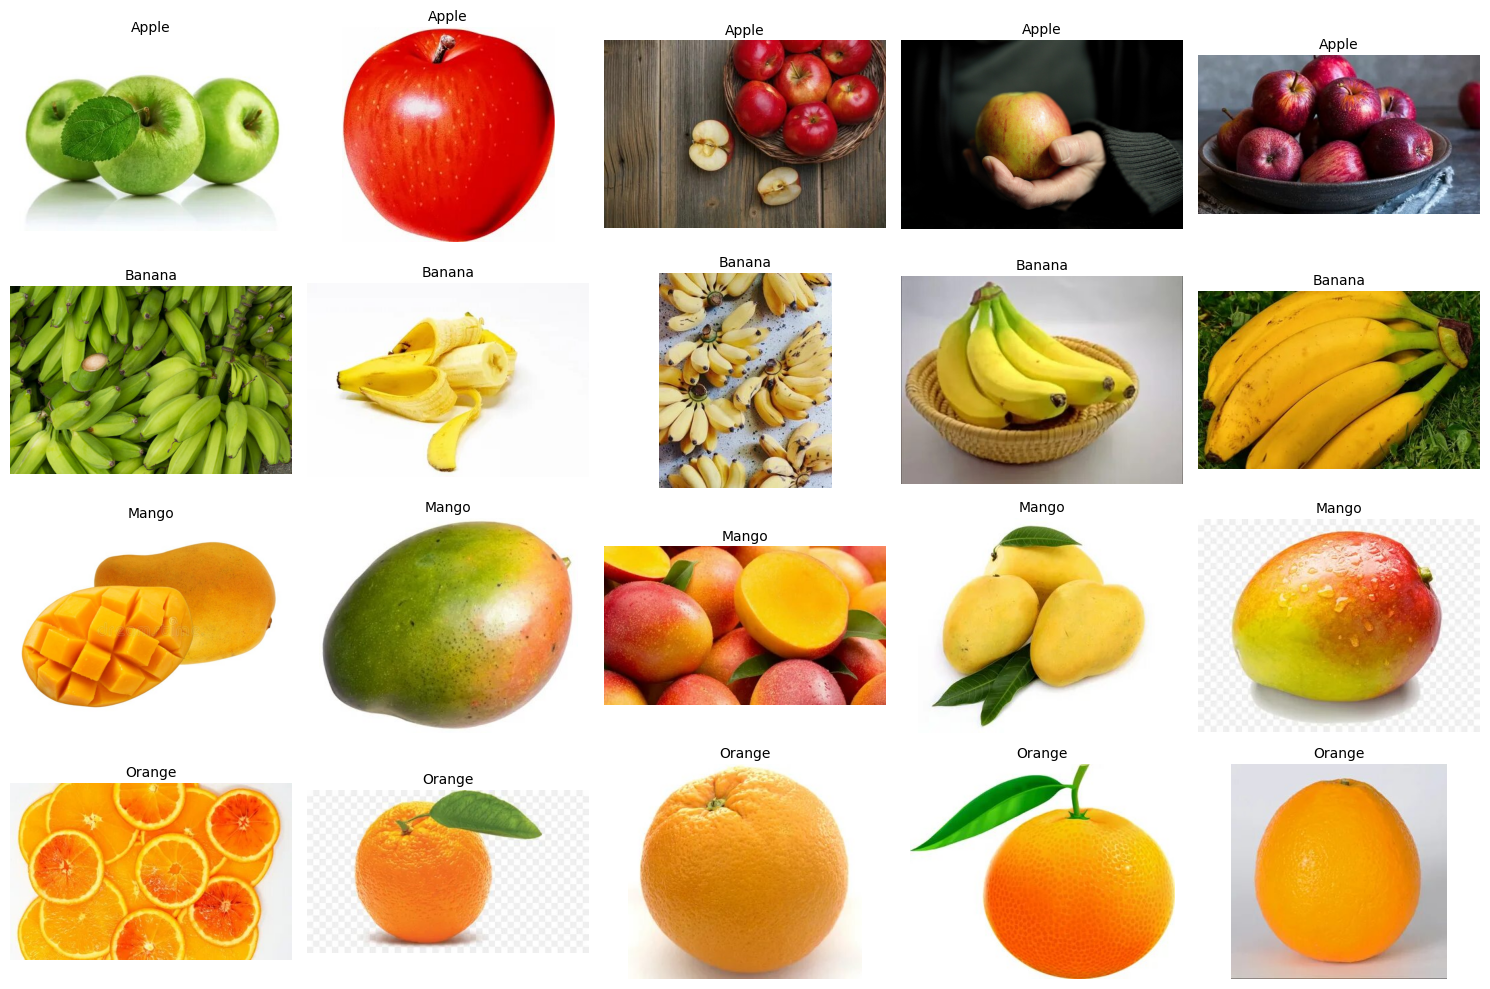

In [17]:
base_path = '/content/fruit_dataset'
random_images = load_random_images(base_path)
plot_images(random_images)

## **Create Test and Val Generators**

In [31]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the entire dataset
dataset = image_dataset_from_directory(
    directory='/content/fruit_dataset/Train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=123
)

# Determine the number of validation samples
validation_split = 0.1
num_validation_samples = int(len(dataset) * validation_split)

# Split the dataset into training and validation sets
train_ds = dataset.skip(num_validation_samples)
validation_ds = dataset.take(num_validation_samples)

# Create a test dataset
test_ds = image_dataset_from_directory(
    directory='/content/fruit_dataset/Test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64, 64)
)

Found 840 files belonging to 4 classes.
Found 216 files belonging to 4 classes.


In [32]:
import tensorflow as tf

# Function to count the number of samples in a dataset
def count_data(dataset):
    count = 0
    for batch in dataset:
        count += batch[0].shape[0]
    return count

# Print the counts of each dataset
train_count = count_data(train_ds)
validation_count = count_data(validation_ds)
test_count = count_data(test_ds)

print(f"Number of training samples: {train_count}")
print(f"Number of validation samples: {validation_count}")
print(f"Number of test samples: {test_count}")

# Prefetch datasets for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Number of training samples: 776
Number of validation samples: 64
Number of test samples: 216


## **Normalize Images**

In [33]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

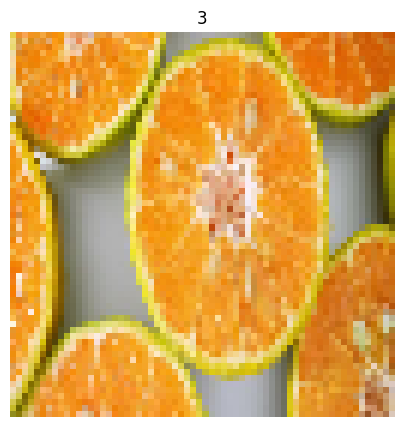

In [34]:
# Function to display an image after Normalization
def display_image_from_ds(dataset):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(5, 5))
        for i in range(1):
            ax = plt.subplot(1, 1, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(int(labels[i].numpy()))
            plt.axis("off")
        break

# Display one of the normalized images from train_ds
display_image_from_ds(train_ds)

## **Discriminator Function**

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

## **Generator Function**

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0 

## **Class to train the models**

In [37]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Unpack the images and labels
        real_images, _ = real_images  # Ignore labels for GAN training

        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## **Periodically save generated images**

In [84]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = 'output_samples_3'  # Specify the output directory

        # Create the output directory if it doesn't exist
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = tf.clip_by_value(generated_images, 0, 255)  # Ensure pixel values are valid
        generated_images = tf.cast(generated_images, tf.uint8)  # Convert to uint8 for saving

        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(self.output_dir, f"generated_img_{epoch:03d}_{i}.png"))  # Save to the output directory

        # Optionally, save a plot of the generated images
        plt.figure(figsize=(10, 10))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i + 1)
            plt.axis('off')
            plt.imshow(img)
        plt.savefig(os.path.join(self.output_dir, f'image_at_epoch_{epoch:04d}.png'))
        plt.close()  # Close the figure to avoid display in notebooks

## **Train the model**

In [85]:
dataset = image_dataset_from_directory(
    directory='/content/fruit_dataset/Train',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(64, 64),
    shuffle=True,
    seed=123
)

def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

dataset = dataset.map(process)

Found 840 files belonging to 4 classes.


In [86]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/100
840/840 [==============================] - 22s 20ms/step - d_loss: 0.6070 - g_loss: 0.9746
Epoch 2/100
840/840 [==============================] - 19s 22ms/step - d_loss: 0.5844 - g_loss: 1.0164
Epoch 3/100
840/840 [==============================] - 20s 24ms/step - d_loss: 0.5807 - g_loss: 1.0607
Epoch 4/100
840/840 [==============================] - 16s 20ms/step - d_loss: 0.5725 - g_loss: 1.0376
Epoch 5/100
840/840 [==============================] - 16s 19ms/step - d_loss: 0.5785 - g_loss: 1.0333
Epoch 6/100
840/840 [==============================] - 17s 20ms/step - d_loss: 0.5622 - g_loss: 1.0669
Epoch 7/100
840/840 [==============================] - 16s 19ms/step - d_loss: 0.5664 - g_loss: 1.0598
Epoch 8/100
840/840 [==============================] - 16s 20ms/step - d_loss: 0.5686 - g_loss: 1.0500
Epoch 9/100
840/840 [==============================] - 18s 21ms/step - d_loss: 0.5700 - g_loss: 1.0557
Epoch 10/100
840/840 [==============================] - 17s 20ms/step - d

## **Display Generated Images**

In [87]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

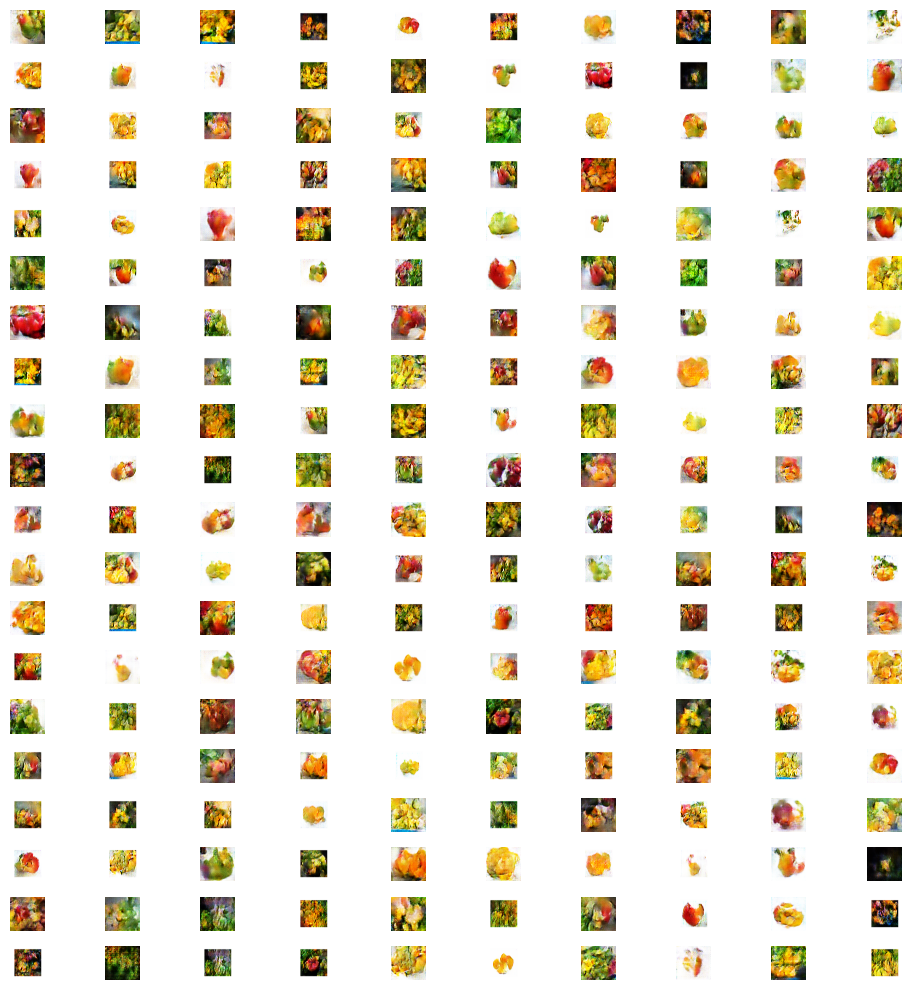

In [88]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Load images
images = []
for img_path in glob.glob('/content/output_samples_3/*.png'):
    images.append(mpimg.imread(img_path))
# Set up the plot
plt.figure(figsize=(10, 10))
columns = 10

# Calculate the number of rows needed
num_rows = math.ceil(len(images) / columns)

for i, image in enumerate(images):
    plt.subplot(num_rows, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## **Downloading Fake Images**

In [91]:
!zip -r /content/output_samples_3.zip /content/output_samples_3

  adding: content/output_samples_3/ (stored 0%)
  adding: content/output_samples_3/generated_img_030_0.png (stored 0%)
  adding: content/output_samples_3/generated_img_058_0.png (stored 0%)
  adding: content/output_samples_3/generated_img_056_0.png (stored 0%)
  adding: content/output_samples_3/image_at_epoch_0004.png (deflated 29%)
  adding: content/output_samples_3/image_at_epoch_0069.png (deflated 31%)
  adding: content/output_samples_3/image_at_epoch_0011.png (deflated 28%)
  adding: content/output_samples_3/generated_img_017_0.png (stored 0%)
  adding: content/output_samples_3/generated_img_010_0.png (stored 0%)
  adding: content/output_samples_3/generated_img_001_0.png (stored 0%)
  adding: content/output_samples_3/generated_img_047_0.png (stored 0%)
  adding: content/output_samples_3/image_at_epoch_0063.png (deflated 29%)
  adding: content/output_samples_3/image_at_epoch_0034.png (deflated 30%)
  adding: content/output_samples_3/image_at_epoch_0038.png (deflated 30%)
  adding: c

In [92]:
from google.colab import files
files.download("/content/output_samples_3.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>